In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
#from b3d.utils import unproject_depth
import rerun as rr
import genjax
from tqdm import tqdm
import os

rr.init("demo.py")
rr.connect("127.0.0.1:8812")
rr.save('multi_particle_visualization_real.rrd')


In [2]:
path = os.path.join(
    b3d.get_root_path(),
    #"assets/shared_data_bucket/input_data/shout_on_desk.r3d.video_input.npz",
    "assets/shared_data_bucket/input_data/kind_bar_falling.r3d.video_input.npz"
)
video_input = b3d.VideoInput.load(path)

In [3]:
# view from the camera 
# Add our camera to the viewer

# rr.log(
#     "world/camera",
#     rr.Pinhole(
#         image_from_camera=scene.cameras[time]["cam_K"], resolution=scene.im_size
#     ),
# )

In [4]:
intrinsics = np.array(video_input.camera_intrinsics_depth)

In [5]:
width=int(intrinsics[0])
height=int(intrinsics[1])
fx=intrinsics[2]
fy=intrinsics[3]
cx=intrinsics[4]
cy=intrinsics[5]
near=intrinsics[6]
far=intrinsics[7]
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [6]:
colors_resized = jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    video_input.rgb, (video_input.xyz.shape[1], video_input.xyz.shape[2], 3), "linear"
) / 255.0
rgbs = colors_resized
xyzs = video_input.xyz

In [7]:
import numpy as np
import cv2
size = 80,80
fps = 10
out = cv2.VideoWriter('kind_patch.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]))
for i in range(30):
    data = np.array(rgbs[238+i,125-40:125+40,55-40:55+40,::-1]*255).astype(np.uint8)
    out.write(data)
out.release()

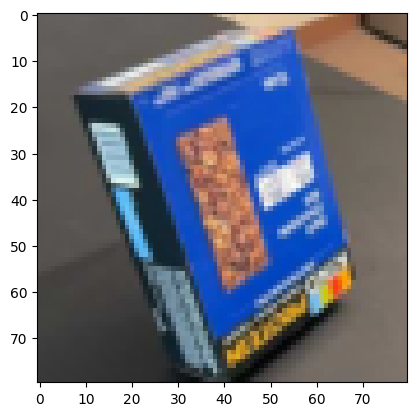

In [8]:
plt.imshow(rgbs[238,125-40:125+40,55-40:55+40,:])

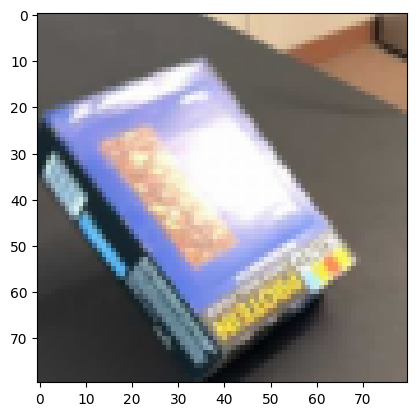

In [9]:
plt.imshow(rgbs[250,125-40:125+40,55-40:55+40,:])

In [10]:
from b3d import Pose

num_layers = 2048
renderer = b3d.Renderer(width, height, fx, fy, cx, cy, near, far, num_layers)
model = b3d.model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

# Arguments of the generative model.
# These control the inlier / outlier decision boundary for color error and depth error.
#color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.02))
color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.01))
# TODO: explain
inlier_score, outlier_prob = (jnp.float32(50.0), jnp.float32(0.001)) # 5
# TODO: explain
color_multiplier, depth_multiplier = (jnp.float32(3000.0), jnp.float32(3000.0))


# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
# Gridding on translation only.

delta = 0.01
translation_deltas = Pose.concatenate_poses([jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-delta, delta, 11),
        jnp.linspace(-delta, delta, 11),
        jnp.linspace(-delta, delta, 11),
    ),
    axis=-1,
).reshape(-1, 3)), Pose.identity()[None,...]])
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses([jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 11*11*11),
    Pose.identity(),
    0.00001, 1000.0
), Pose.identity()[None,...]])
all_deltas =  Pose.stack_poses([translation_deltas, rotation_deltas])

In [11]:
def get_trajs(key, x_center, y_center, rgbs, xyzs, time_start = 0, timesteps = len(xyzs), del_pix=5):
    # Make empty library
    object_library = b3d.MeshLibrary.make_empty_library()

    # x_center = 35
    # y_center = 45 
    # del_pix = 5 

    local_points = xyzs[time_start,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
    local_rgbs = rgbs[time_start,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
    patch_center = xyzs[time_start,x_center,y_center,:]

    point_cloud = local_points
    point_cloud_colors = local_rgbs

    # Create new mesh.
    vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
        point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
    )
    object_pose = Pose.from_translation(vertices.mean(0))
    vertices = object_pose.inverse().apply(vertices)
    object_library.add_object(vertices, faces, vertex_colors)
    model_args = b3d.model.ModelArgs(color_error, depth_error,
                                inlier_score, outlier_prob,
                                color_multiplier, depth_multiplier)

    trace, _ = importance_jit(
        jax.random.PRNGKey(0),
        genjax.choice_map(
            dict([
                ("camera_pose", Pose.identity()),
                ("object_pose_0", object_pose),
                ("object_0", 0),
                ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
            ])
        ),
        (jnp.arange(1),model_args, object_library)
    )


    FINAL_T = timesteps+time_start
    patches = []
    patch_centers = []

    for T_observed_image in tqdm(range(time_start, FINAL_T)):
        # Constrain on new RGB and Depth data.
        trace = b3d.update_choices_jit(trace, key,
            genjax.Pytree.const(["observed_rgb_depth"]),
            (rgbs[T_observed_image],xyzs[T_observed_image,...,2])
        )
        trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
        trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

        patch_center = (trace["camera_pose"].inv() @ trace[f"object_pose_0"]).apply(jnp.mean(object_library.vertices,axis=0))
        patch = (trace["camera_pose"].inv() @ trace[f"object_pose_0"]).apply(object_library.vertices)
        patches.append(patch)
        patch_centers.append(patch_center)

    return jnp.array(patches), jnp.array(patch_centers)




In [12]:
num_frames = 100
frame_start = 200
patches, patch_centers = get_trajs(key,35,45,rgbs,xyzs,frame_start,num_frames)

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


In [13]:
# jit this code?

In [14]:
center_arr = []
center_x = 135
center_y = 85
window = 100
patch_size = 5

for i in np.arange(center_x-window//2,center_x+window//2,patch_size):
    row_arr = []
    for j in np.arange(center_y-window//2,center_y+window//2,patch_size):
        row_arr.append(get_trajs(key, i, j, rgbs, xyzs, frame_start, num_frames)[1])
    center_arr.append(row_arr)

  0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [00:18<00:29,  2.08it/s]


KeyboardInterrupt: 

In [ ]:
center_arr = jnp.array(center_arr)
center_arr = center_arr.reshape(-1,num_frames,3)

In [ ]:
num_points = center_arr.shape[0]

for t in range(num_frames):
    rr.set_time_sequence("frame", t)

    points = rr.Points3D(xyzs[t].reshape(-1,3), colors=rgbs[t].reshape(-1,3), radii = 0.0005*np.ones(xyzs[t].reshape(-1,3).shape[0]))
    rr.log("cloud1", points)

    points2 = rr.Points3D(center_arr[:,t,:], radii=0.0075*np.ones(center_arr.shape[0]), colors =np.repeat(np.array([0,0,255])[None,...], num_points, axis=0))
    rr.log("cloud2", points2)

    rr.log("/rendered_im", rr.Image(rgbs[t]))

    num_frames_trail = 5
    if t > num_frames_trail:
        rr.log(
            "strips",
            rr.LineStrips3D(np.array(center_arr[:,t:t-num_frames_trail:-1,...]), colors=np.repeat(np.array([0,255,0])[None,...], num_points, axis=0), 
            radii= 0.0025*np.ones(num_points))
        )

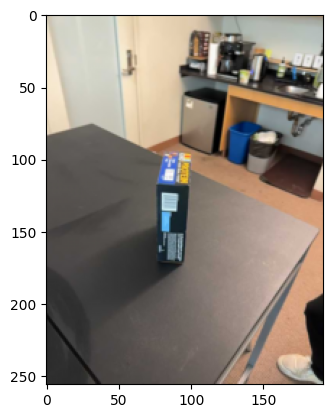

In [ ]:
plt.imshow(rgbs[200])

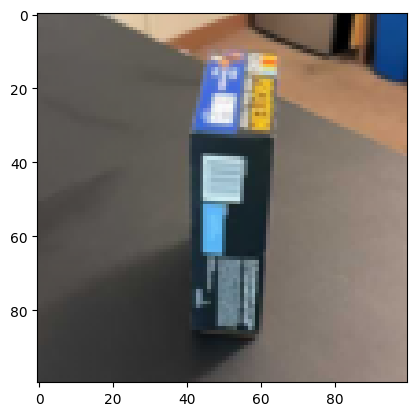

In [ ]:
plt.imshow(rgbs[200,135-50:135+50,85-50:85+50,:])

In [ ]:
## TODO: get this working on two boxes, and test the rigidity

In [ ]:
## dense tracking, heuristic cluster - end to end demo

In [ ]:
# plot depth image evolving as a point cloud
# plot location of tracker centroids
# plot location of tail plots

In [ ]:
# show ground truth renderings on top for visualization

In [ ]:
# use particle grid variance to determine if particles can be dropped 
# dyanamics-based culling (bounding box over velocity values and expected position, send scores to zero if they're outside the bounding box)